In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from split import *
from score import *
from scipy import interpolate
import time 
%matplotlib inline 
import warnings 
warnings.simplefilter('ignore', np.RankWarning)
import matplotlib 



"""
Title:       Search_By_Triplet.

Autor:       Piter Amador Paye Mamani.

Description:
             This python-code is an implementation of the algorithm Search By Triplet that was inspired on the work of
             Daniel Campora. 
             
Changes:
1.  Squeletum of the algorithm
2.  First Tracks. 
3. 
4. 
5.  Adding exceptions. 
6.  I've deleted unnecessary comments. Also, I was getting an error at time to compute findcandidatewindows.
    Problems. One get the values of tracks 
7.  Changing the jerarquy of the function, according to the paper. It means that findcandidatewindows is calculated
    on all modules befero they were processed.
6. 
7. 
8.   
9.  Adding timing information.
10. Add pixel information.
"""




"\nTitle:       Search_By_Triplet.\n\nAutor:       Piter Amador Paye Mamani.\n\nDescription:\n             This python-code is an implementation of the algorithm Search By Triplet that was inspired on the work of\n             Daniel Campora. \n             \nChanges:\n1.  Squeletum of the algorithm\n2.  First Tracks. \n3. \n4. \n5.  Adding exceptions. \n6.  I've deleted unnecessary comments. Also, I was getting an error at time to compute findcandidatewindows.\n    Problems. One get the values of tracks \n7.  Changing the jerarquy of the function, according to the paper. It means that findcandidatewindows is calculated\n    on all modules befero they were processed.\n6. \n7. \n8.   \n9.  Adding timing information.\n10. Add pixel information.\n"

In [23]:
def rho(x,y):
    return np.sqrt(x*x + y*y)
def r(x,y,z):
    return np.sqrt(x*x + y*y + z*z)
def theta(x,y,z):
    return np.arccos(z/r(x,y,z))
def phi(x,y):
    return np.arctan(y/x)
def module(r):
    return np.sqrt(np.sum(r*r))
def r_e(z, r_l, r_c):
    z_c = r_c[2] 
    r_versor = (r_l - r_c)/module(r_l - r_c)               # computing r_versor
    r_versor_dot_z_versor = r_versor[2]  
    return r_c - r_versor/r_versor_dot_z_versor*(z_c - z)  # IMPORTANT WITH THE MINUS SIGN.

In [24]:
def reading_data(fraction):
    name = 'data/RAMPData55microns50psInner200microns50psOuter_train.txt' # To be modified for others. 
    data_fraction = fraction
    
    df = pd.DataFrame()
    df = pd.read_csv(name, sep=' ') # All data.
    df,_ = Split_frac(df, data_fraction)
    return df

In [25]:
# DATAFRAME will be a global data. 
fraction = 0.004
df       = reading_data(fraction)  

In [26]:
def sortbyphi(df):
    '''Description:
    Sort each D_i increasingly accoording to phi
    And add a column to the dataframe_module with the name of used to accept or neglect hits. 
    '''
    z = np.sort(df['z'].unique())
    df['phi'] = np.arctan(df['x']/df['y'])
    modules = [] 
    for layer_i in z[::-1] :
        tmp = df.query(f'z=={layer_i}')
        tmp = tmp.sort_values('phi', ascending=True)
        # IMPORTANT 
        tmp['used'] = False # 
        modules.append(tmp)  
    return modules       

In [27]:
PHI = []
def findcandidatewindows(left_mod, mod, right_mod ):
    # phi_window     =  phi_extrapolation_base + np.abs( hit_Zs[h_center]) * phi_extrapolation_coef 
    global phi_extrapolation_coef, phi_extrapolation_base
    '''Description: 
        Compute the first and last candidates(the window) according to acceptance range(dphi) for each hit.
        SUPPOSSING THAT ALL DATA ARE ORDERED ACCOURDING TO PHI. THIS PROCCESS WAS DONE Previously
        In case of add more information to the modules, one easily can add throught the iteration 
    '''
    # CONVENTION :     
    # l_m  m  r_m   the values are ordered.      
    #  |   |   |             
    #  |   |   |    phi up  
    #  |   |   |    phi      
    #  |   |   |    phi down 
    #  |   |   |          
    
    right_hit_max = [] 
    right_hit_min = [] 

    temporal = mod['phi'] 
    
    # ITERATION OVER PHI FOR RIGHT 
    
    for phi_i in mod['phi']: 
        #print("=")
        #print(phi_i)
        if str(phi_i) == 'nan' :     
            #print(phi_i, "the value of phi_i is NaN ON RIGHT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            right_hit_min.append(m) 
            right_hit_max.append(M) 
            continue # 
        if str(phi_i) == 'NaN' :     
            #print(phi_i, "the value of phi_i is NaN ON RIGHT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
            
        
        z_center = mod['z'].unique()[0]
        #z = df.query(f"phi=={phi_i}")["z"].values[0]
        # GET HIT 
        dphi =  phi_extrapolation_base + np.abs( z_center ) * phi_extrapolation_coef

        PHI.append(dphi)
        
        
        
        down      = phi_i - dphi 
        up        = phi_i + dphi 
        #print(down, up)
        
        condition = f'{down} <= phi <=  {up}'
        tmp_df = right_mod.query(condition)
        if not tmp_df.empty:
            m = tmp_df['hit_id'][tmp_df.index[0]]     # minumum hit 
            M = tmp_df['hit_id'][tmp_df.index[-1]]    # maximum hit 
            right_hit_min.append(m) 
            right_hit_max.append(M) 
        elif tmp_df.empty :

            m = "nan" #pd.np.nan                      # minumum hit 
            M = "nan" #pd.np.nan                      # maximum hit
            right_hit_min.append(m)  
            right_hit_max.append(M) 
            
    left_hit_max = [] 
    left_hit_min = [] 
    # ITERATION OVER PHI FOR LEFT
    for phi_i in mod['phi']:
        if str(phi_i) == 'NaN' :     
            # print(phi_i, "the value of phi_i is NaN ON LEFT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
        if str(phi_i) == 'nan' :     
            # print(phi_i, "the value of phi_i is NaN ON left")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            continue # 
        
        # GET HIT 
        down      = phi_i - dphi 
        up        = phi_i + dphi 
        condition = f'{down} <= phi <= {up}'
        tmp_df = left_mod.query(condition)
        #print("len LEFT", len(tmp_df))
        if not tmp_df.empty :
            m = tmp_df['hit_id'][tmp_df.index[0]]        # minumum hit 
            M = tmp_df['hit_id'][tmp_df.index[-1]]       # maximum hit  
            left_hit_min.append(m)
            left_hit_max.append(M)
        elif tmp_df.empty :
            # print("data_frame is empty LEFT")
            m = "nan"               # minumum hit 
            M = "nan"               # maximum hit
            left_hit_min.append(m) 
            left_hit_max.append(M) 
            
    mod["right_hit_max"] = right_hit_max  
    mod["right_hit_min"] = right_hit_min  
    mod["left_hit_max"]  = left_hit_max   
    mod["left_hit_min"]  = left_hit_min   
    return mod

###############################################


In [28]:
def trackseeding():
    global left_mod, mod, right_mod, M_i
    
    '''
    Description: 
        Checks the preceding and following modules for compatible hits using the above results.
        
        All triplets in the search window are fitted and compared.
        
        and the best one is kept as a track seed.
        
        stores its best found triplet
        Finding triplets is ap- plied in first instance to the modules
        that are further apart from the collision point
        Each triplet is the seed of a forming track
    '''

    #Necessary functions.
    def fit(triplet): 
        phi_data = [ df.query(f'hit_id == {hit}')['phi'] for hit in triplet ]
        z_data   = [ df.query(f'hit_id == {hit}')['z']   for hit in triplet ]
        phi_data = [ hit.values[0] for hit in phi_data                      ]                        
        z_data   = [ hit.values[0] for hit in z_data                        ]                    
        # Kind of fit: Linear
        fitting = np.polyfit(phi_data, z_data, 1)
        # IMPORTANT  
        # REMEMBER TO PUT HERE THE VALUES OF SIGMA. 
        # IMPORTANT 
        chiSquared = np.sum((np.polyval(fitting, z_data) - phi_data)**2)
        return chiSquared    
    df_triplets = []
    
    # print("len of mod. ","in module #", M_i )
    # print(len(mod) )
    
    for index, part in mod.iterrows():

        r_hit_max, r_hit_min = part["right_hit_max"], part["right_hit_min"]  
        l_hit_max, l_hit_min = part["left_hit_max"],  part["left_hit_min" ] 
        
        if  str(r_hit_max)  == "nan":
            #print(r_hit_max)
            # print("CONTINUE")
            continue 
        elif str(r_hit_min) == "nan":
            #print(r_hit_min)
            #print("pass NAN r_hit_min")
            continue 
        elif str(l_hit_max) == "nan":
            #print(l_hit_max)
            #print("pass NAN l_hit_max")
            continue 
        elif str(l_hit_min) == "nan":
            #print(l_hit_min)
            #print("pass NAN l_hit_min")
            continue  
            
        if  str(r_hit_max)  == "NaN" :
            #print(r_hit_max)
            #print("pass NAN r_hit_max")
            continue 
        elif str(r_hit_min) == "NaN" :
            #print(r_hit_min)
            #print("pass NAN r_hit_min")
            continue 
        elif str(l_hit_max) == "NaN" :
            #print(l_hit_max)
            #print("pass NAN l_hit_max")
            continue 
        elif str(l_hit_min) == "NaN" :
            #print(l_hit_min)
            #print("pass NAN l_hit_min")
            continue  
        
        r_phi_max = right_mod.query(f"hit_id == {r_hit_max}")['phi'].values[0]
        r_phi_min = right_mod.query(f"hit_id == {r_hit_min}")['phi'].values[0] 
        
        l_phi_max = left_mod.query(f"hit_id == {l_hit_max}")['phi'].values[0]  
        l_phi_min = left_mod.query(f"hit_id == {l_hit_min}")['phi'].values[0]  
        
        left_mod.query(f" {l_phi_min} <= phi <= {l_phi_max}")
        #Forming all Triplets. 
        # Here I am adding the condition of used and not used.
        # After of this I need to change the condition of used and not used. 
        # 
        #print("_left")
        #print(_left)
        #tmp_left = left_mod.query(f" {l_phi_min} <= phi <= {l_phi_max}")
        tmp_right = right_mod.query(f"   {r_phi_min} <= phi <= {r_phi_max} & used == False  ")    # ADDING TIME
        for R in tmp_right['phi'].values:
        #for L in tmp_left['phi'].values: 
            #tmp_right = right_mod.query(f" {r_phi_min} <= phi <= {r_phi_max}")
            #tmp_right = right_mod.query(f" {r_phi_min} <= phi <= {r_phi_max}")
            tmp_left = left_mod.query(f" {l_phi_min} <= phi <= {l_phi_max} & used == False ")     # ADDING TIME
            #print("tmp_right")
            #print(tmp_right)
            #for R in tmp_right['phi'].values:
            #tmp_left = left_mod.query(f" {l_phi_min} <= phi <= {l_phi_max}")
            for L in tmp_left['phi'].values: 
                
                #print(L, hit_center, R)
                
                # I WILL SUPPOSE THAT 
                # All information it is found on the hit values.
                # print("VALUES  center left right ")
                
                hit_center = int(part["hit_id"])
                
                #print("HIT_CENTER")
                #print("HIT_CENTER")
                #print(hit_center)  
                #print(part["hit_id"])
                hit_left   = int(tmp_left.query(f" phi == {L}")['hit_id'].values[0]  )    
                #print(tmp_left.query(f" phi == {L}")['hit_id'].values)
                hit_right  = int(tmp_right.query(f" phi == {R}")['hit_id'].values[0] )                          
                #print(tmp_right.query(f" phi == {R}")['hit_id'].values)
                # With this data we have built the triplets. 
                triplets = [hit_left, hit_center, hit_right]
                # This a lost of memory. I mean that call by hits and not by values is a lost 
                # of memory.
                #print("triplets")
                #print("triplets")
                #print("triplets")
                #print(triplets)
                chi2 = fit(triplets)                                                                                                                                                                
                # Finally we append the values of the data to a df_triplets
                #print("####?###")
                #print(triplets)
                #print(chi2)
                #print("#######")
                df_triplets.append(list(triplets)+[chi2])
                
    
                
    df_triplets = pd.DataFrame(df_triplets, columns = ['left_hit', 'hit', 'right_hit', 'chi2'])  
    # Up to this point it is necessary to have the values of df_triplets complete
    # Then the algorithm should continue to get the best choices according to the values
    # of chi2.
    def best_choice(df_triplets):
        seeds = []
        for hit_c in df_triplets['hit'].unique() : # UNIQUE
            #print("hit")
            #print(hit_c)
            #print("hit -----")
            # GROUPING 
            tmp = df_triplets.query(f'hit == {hit_c}')
            minimum = (tmp['chi2']).idxmin()
            #i = chi2values.idxmin() # Here we choice the values.
            #tracks.append((tmp.loc[i]).values) 
            t = (tmp.loc[minimum]).values            
            t = [int(i) for i in t]
            #these are the triplets       
            seeds.append(list(t[:3]))     # Here I am negleting the information chi2 because is not important
        return seeds                      # obviously it is a track

    seeds = best_choice(df_triplets)
    
    #print("len seeds  ")
    #print(len(seeds))

    return seeds

In [29]:
def track_forwarding():
    # Here I have to review the leff_mod
    # So, I am beging to print the value of left_mod on three steps 
    global tracks, work_module, left_mod, mod, right_mod, M_i, weak_tracks 
    
    # for 
    global phi_extrapolation_coef, phi_extrapolation_base 
    
    
    new_tracks = [] 
    # Notation:
    # x0, y0, z0 is the EXTRAPOLATED track.               
    # X,  Y,  Z  is the last track on previous module.   
    # x,  y,  z  is the tracks on a window.                                                                 
    # Searching tracks on phi_e - dphi < phi < phi_e + dphi that minimize the extrapolated function.
    # r0 = np.array([x0, y0, z0] )
    # r  = np.array([x, y, 1] )
    # R  = np.array([X,  Y,  Z ] )
    def module(r):
        return np.sqrt(np.sum(r*r))
    def ext_func(r0, r1, r):
        # r0, r1, r are arrays
        dx2_plus_dy2 = module(  r0-r )     # distance between hits on the working module.  
        dz2          = module( r1-r0 )     # distance between the last two modules.                                  
        return dx2_plus_dy2/dz2 
    
    z_e = float(work_module['z'].unique()) #z_position of work_module                    
    
    # here the track is exactly the seed. Only for the 1th iteration
    for track in tracks: 
        #PROOF: Do you have the track values information of USED ?
        data = []          
        vector_data = []  
        
        #EXTRAPOLATION ONLY WITH TWO LAST HITS
        
        for hit in track[0:2] :
            data.append(tuple((df.query(f'hit_id == {hit}')[['phi', 'z']]).values[0]))     
            vector_data.append(tuple((df.query(f'hit_id == {hit}')[['x', 'y', 'z']]).values[0]))
        phi_data, z_data = zip(*data) 
        #EXTRAPOLATED SEGMENT FUNCTION      
        ext_seg = interpolate.interp1d(z_data, phi_data, fill_value = "extrapolate" )
        phi_e   = ext_seg(z_e) 
        r_l, r_c = vector_data                   # THE VALUES ON LEFT AND RIGHT                                                
        r_l, r_c = np.array(r_l), np.array(r_c)  # 
        x_e, y_e, z_e = r_e(z_e, r_l, r_c)       # COMPUTING THE VALUES ON THE WORKING MODULE.                                 
        
        #Open a Window centered on phi_e: 
        z_center = mod['z'].unique()[0]
        #z = df.query(f"phi=={phi_i}")["z"].values[0]
        # GET HIT 
        dphi =  phi_extrapolation_base + np.abs( z_center ) * phi_extrapolation_coef
        down = phi_e - dphi
        up   = phi_e + dphi   

        if str(down) == 'nan' or str(down) == 'NaN' or str(up) == 'nan' or str(up) == 'NaN' :
            print("An error ocurred with the values of down or up. Plese cheack.")
            break
        
        #################################### WINDOW ########################### 
        df_work_module_window = work_module.query(f" {down} <= phi <= {up} " )  
        #print("df_work_module_window")
        #print(df_work_module_window.head())
        
        
        
        #This definition will be done after the loop. 
        #df_candidates = pd.DataFrame(columns=["hit_id", "ext_fun"]) # This dataframe have to be reviwed 
        hit_left = track[0]   
        R  = df.query(f'hit_id == {hit_left}')[['x','y','z']].values[0] # this value would have to change on each track
        r0 = np.array([x_e, y_e ,z_e ])

        tmp_candidates = []
        for index, row in df_work_module_window.iterrows(): 
            # Here I only need to have the information of position.
            r      =  row[['x', 'y', 'z']].values # this value is variable on each row.
            hit_id =  row['hit_id']    
            ext_func_value = ext_func(r0, R, r)
            tmp_candidates.append( [hit_id, ext_func_value] )
        
        #"************************************************************************************************************" 
        #"************************************If any extrapolated data is not founded on the working module **********" 
        #"************************************************************************************************************"
        
        if tmp_candidates == [] :                                             
            #print("an error ocurred: with tmp_candidates is empty continue ")    
            print(f" Not added a new track on the module # {M_i} - 2 ")
            # We 
            # Here we put the tracks on a new list named waked_tracks
            if len(track) == 3: 
                weak_tracks.append(track)
                continue
            else :
                # we do not lost the track
                new_track = [] + track  
                new_tracks.append(new_track)
                continue  
           
        # ¿ ******************************************************************************************************** ? " 
        # "************************************************************************************************************" 
        # "************************************tmp_candidates**********************************************************" 
        # "************************************************************************************************************"
                
        df_candidates = pd.DataFrame(tmp_candidates, columns=["hit_id", "ext_fun"])
        #Choosing new hit_id to complete the track. 
        new_hit_id    = df_candidates.loc[df_candidates['ext_fun'].idxmin()]['hit_id']
        new_hit_id    = int(new_hit_id)   # new_hit_id   
    
    
        # MARKING EACH HIT AS USED ON THE WORKING MODULE        
        work_module.loc[ work_module.hit_id == new_hit_id, "used" ]  = True   
        
        if len(track) == 3 :
            # #########     MARKING TRIPLES######  
            # MATCHING EACH HIT AS USED ON THE WORKING MODULE  

            hit_id_left, hit_id_center, hit_id_right = track[0:3] 

            #LEFT
            left_mod.loc[left_mod.hit_id == hit_id_left, "used"]     = True
            #CENTER
            mod.loc[        mod.hit_id == hit_id_center, "used"]     = True
            #RIGTH
            right_mod.loc[right_mod.hit_id == hit_id_right, "used"]  = True

            # FINALLY we add the new track to the value of tracks
            # ADDING to track
        new_track     = [new_hit_id] + track  
        new_tracks.append(new_track)
         
    return new_tracks  # this value will be replaced by tracks on the main algorithm




# MAIN

In [30]:
########################################################################################
################################## MAIN ################################################
########################################################################################
############################ GENERAL ALGORITHM #########################################
############################     PARAMETERS    #########################################
########################################################################################
########################################################################################
########################################################################################

fraction = 0.004 # 
dphi     = 0.1   # The windows is a variable quantity that depend on phi_ext_base ###### 
# phi_window     =  phi_extrapolation_base + np.abs( hit_Zs[h_center]) * phi_extrapolation_coef         ;

phi_extrapolation_coef = 0.0002
phi_extrapolation_base = 0.03 

m        = 18    # number of modules counted from the left.                           #
                 # from 1 to 24. No more. 

new_tracks = []                      # 
df = reading_data(fraction)          # where data is unmodified.
# df_search   = df_original          # where I am searching 
tracks = []                          # [[1,24, 5], [7,6,4] ,[346,7,32,], ... ]
weak_tracks  =[]                     # 123
# *********************IMPORTANT**********************************************
# The information of tracks is ordered. 
# Because each of its elements are an ordered list according to module layers.
# However, the information of hits are unique and not matter if are a ordered set. 
# But it was filled out in order



# SEPARATION BY MODULE  
modules = sortbyphi(df)  
# FIND CANDIDATE WINDOWS. In order to minimize the amount of candidates considered in subqsequent steps.
for M_i in range(len(modules)-1, len(modules)-m-1, -1):
    M_i = M_i - 1
    left_mod     =  modules[M_i - 1]  
    right_mod    =  modules[M_i + 1]
    mod          =  modules[M_i    ]
    modules[M_i] =  findcandidatewindows(left_mod, mod, right_mod)
    
#ITERATION OVER MODULES ( ):
for M_i in range(len(modules)-1, len(modules)-m-1, -1): 
#for M_i in range(22, 20, -1):
    t1 = time.time()                
    print(f"module number {M_i}")
    M_i = M_i - 1
    #1th STEP: module #m-1 = M_i
    left_mod  =  modules[M_i - 1]  
    mod       =  modules[M_i    ]  
    right_mod =  modules[M_i + 1] 

    new_seeds  = trackseeding()     
    # REASIGNING VALUES    
    modules[M_i - 1] =  left_mod           
    modules[M_i    ] = mod              
    modules[M_i + 1] = right_mod        
    #Adding new seeds to tracks 
    tracks = tracks + new_seeds
    # Defining a new variable.  
    work_module = modules[M_i - 2] 
    
    
    
    #print(left_mod['used'], mod['used'], right_mod['used'])

    tracks  = track_forwarding() 
    #Reasigning 
    modules[M_i - 2] = work_module
    #
    t2 = time.time()
    print("time per module", t2-t1) 
tracks = pd.Series(tracks)

#print("FINDING TRACKS FINISHED")



######################
######  FINALLY  #####
###### COMPARING #####
######################
######################

output = []
for x in tracks:
    if x not in output:
        output.append(x)
    else:
        print("repeated")
tracks_1 = output

df_real_tracks = df.groupby(['particle_id'])['hit_id'].unique() # this is a series.
Scoring(df_real_tracks, tracks)
#######################




module number 24
time per module 1.0315217971801758
module number 23
 Not added a new track on the module # 22 - 2 
time per module 0.5583028793334961
module number 22
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
 Not added a new track on the module # 21 - 2 
time per module 0.473660945892334
module number 21
 Not added a new track on the module # 20 - 2 
 Not added a new track on the module # 20 - 2 
 Not added a new track on the module # 20 - 2 
 Not added a new track on the module # 20 - 2 
 Not added a new track on the module # 20 - 2 
 Not added a new track on the module # 20 - 2 
 Not added a new track on the module # 20 - 2 
 Not added a new track on the

{'efficiency': 0.8636363636363636,
 'fake_rate': -0.08571428571428572,
 'clone_rate': 0.05714285714285714}

In [31]:
Scoring(df_real_tracks, tracks_1)

score: 0.9136920222634507


{'efficiency': 0.8636363636363636,
 'fake_rate': -0.08571428571428572,
 'clone_rate': 0.05714285714285714}

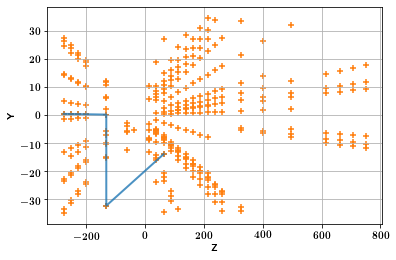

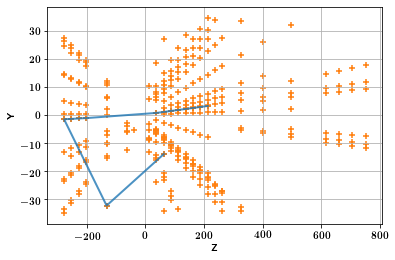

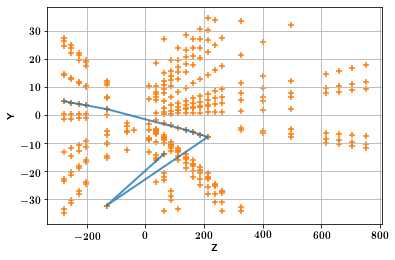

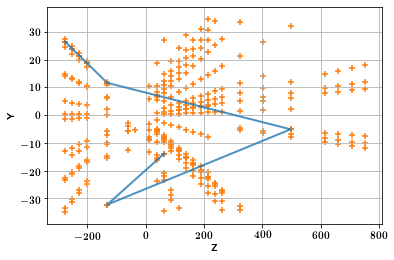

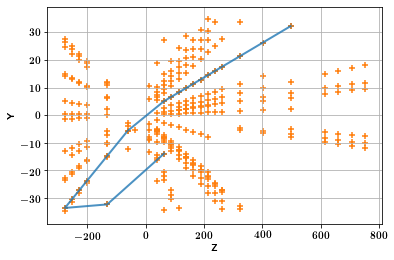

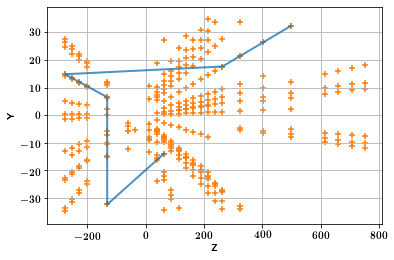

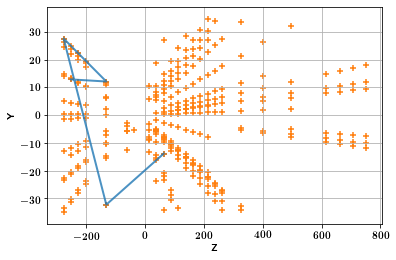

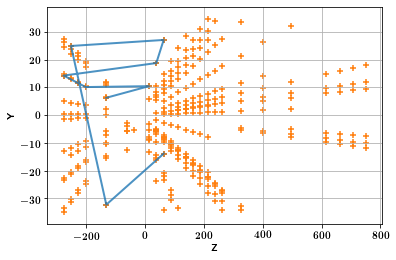

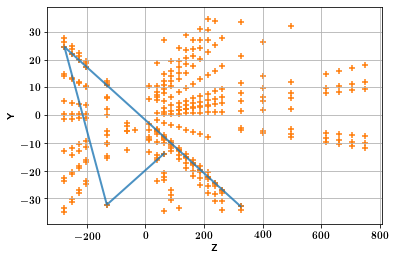

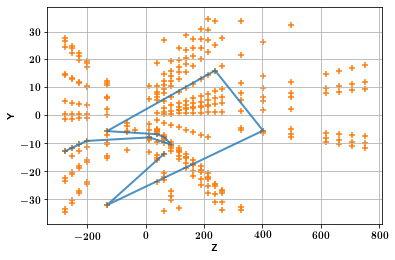

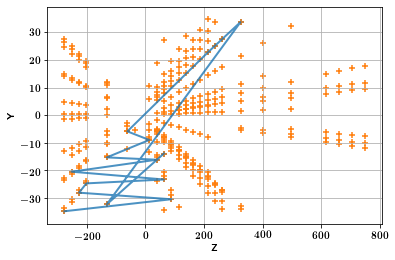

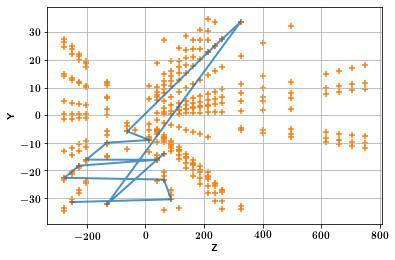

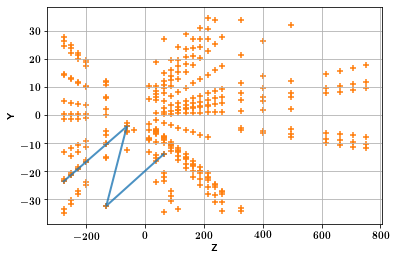

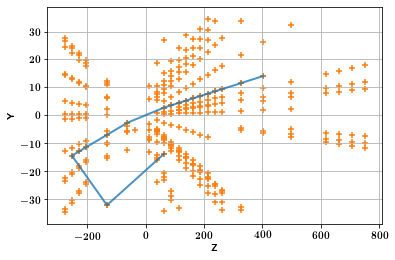

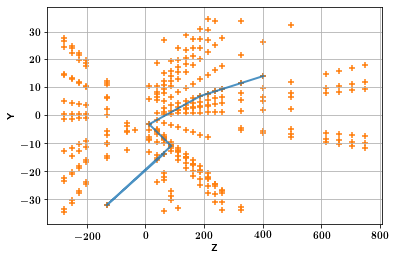

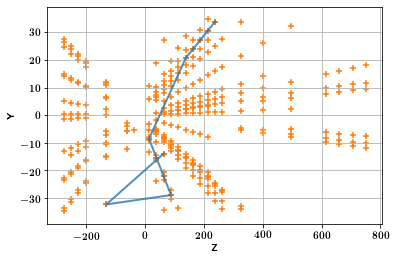

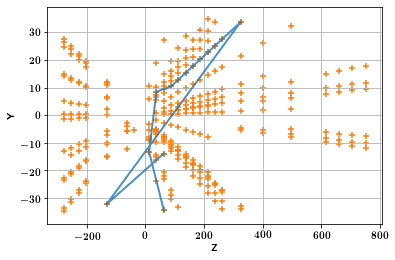

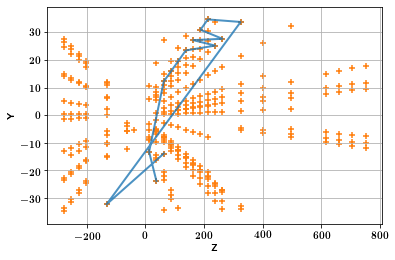

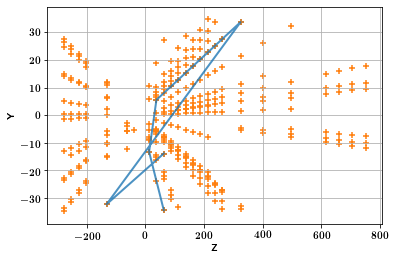

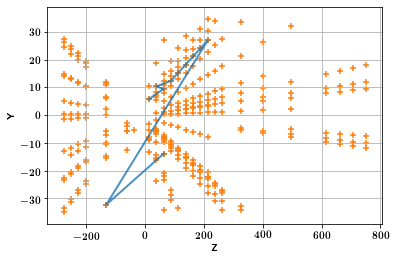

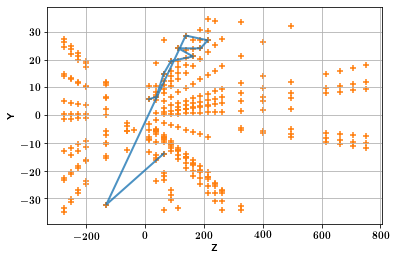

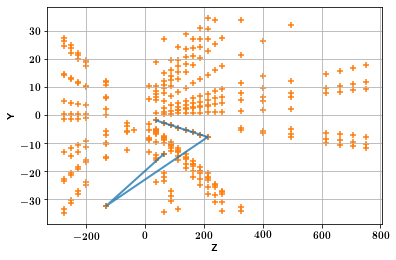

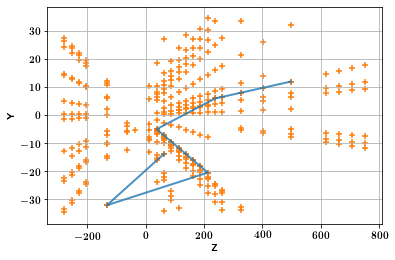

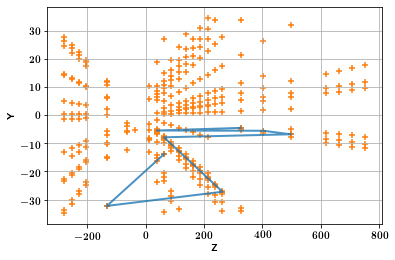

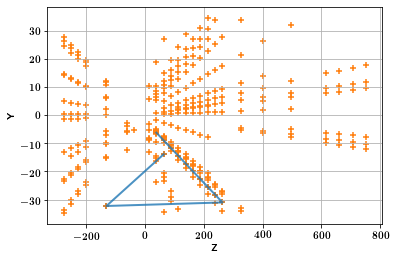

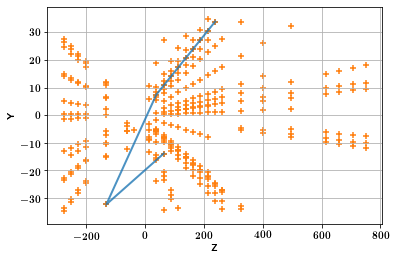

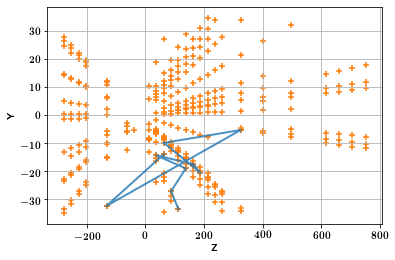

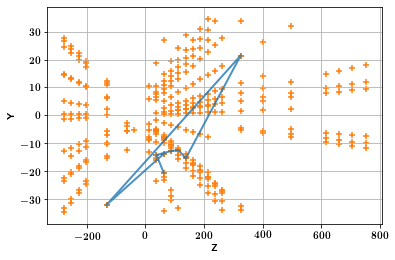

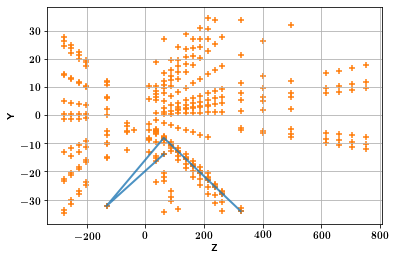

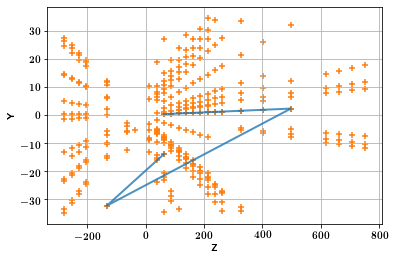

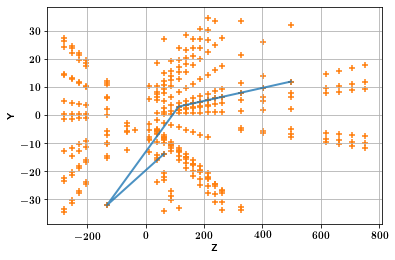

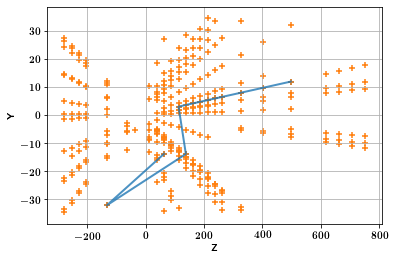

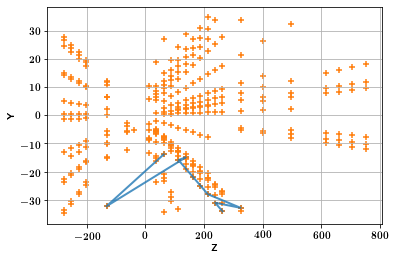

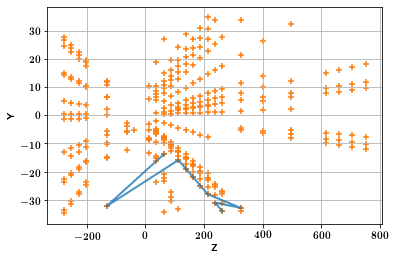

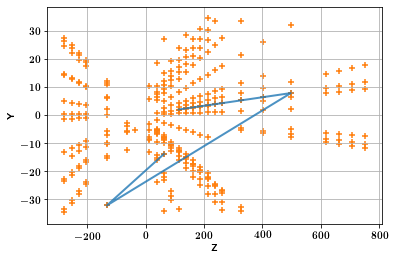

In [32]:
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

# List will be used to create a text file 
# Create plots to show the reconstructed tracks

plt.figure()

tracks  = tracks + weak_tracks
for track in tracks:
    # Here I can get the values of the orignal dataframe.
    data = []
    for hit in track : # 
        data.append(list(df.query(f"hit_id == {hit}").values[0])) # what kind of data we want.
    data = pd.DataFrame(data, columns=list(df.columns.values) ) 
    plt.plot(data['z'], data['y'], '-', alpha=0.8, lw=2)
    plt.scatter(data['z'], data['y'], marker='+' )
    plt.scatter(df['z'], df['y'], marker='+' )
    plt.xlabel(r"\textbf{Z}")
    plt.ylabel(r'\textbf{Y}')
    plt.grid(True)
    tracks.append(data['hit_id'])
    plt.show()